# Fuzzy VAE for semi-supervized learning

Semi-supervised learning CVAE with fuzzy layer on MNIST dataset.

Table of content:

<a class="anchor" id="bcImp"></a>
* [<b>Import dependencies and load the data</b>](#importData)
* [<b>Build fuzzy VAE model</b>](#buildModel)
* [<b>Visualizations</b>](#viz)

## 1. Import dependencies and load the data <a class="anchor" id="importData"></a>
[Back to Table of Contents](#bcImp)

In [41]:
import sys 
sys.path.insert(0, 'D:/projects/KerasFuzzy/KerasFuzzy/layers')
from fuzzy_layer_2 import FuzzyLayer2
from fuzzy_layer_bell_shaped import FuzzyLayerBell
from fuzzy_layer import FuzzyLayer
from defuzzy_layer_2 import DefuzzyLayer2
from defuzzy_layer import DefuzzyLayer

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(2)
random_seed = 2
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from keras.utils.np_utils import to_categorical
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras import backend as K 
import random
from keras.callbacks import EarlyStopping
from keras.callbacks import LearningRateScheduler
import datetime

In [42]:
train = pd.read_csv("./datasets/train.csv")
test = pd.read_csv("./datasets/test.csv")

Y_train = train["label"]

X_train = train.drop(labels = ["label"], axis = 1) 
del train 

In [43]:
X_train = X_train / 255.0
X_train = X_train.values.reshape(-1,28,28,1)

Y_train = to_categorical(Y_train, num_classes = 10)
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size = 0.1, random_state=random_seed)

In [44]:
# randomly put labels to all zero values to mark them as 'missing' supervised label
import random
for y_t in Y_train:
   if random.random()>0.4:
       for i in range(10):
           y_t[i] = 0

## 2. Build fuzzy VAE model <a class="anchor" id="buildModel"></a>
[Back to Table of Contents](#bcImp)

Model structure is mostly similar to CVAE with additional normalization loss except modification to Poisson loss. That modifications was indroduced to exclude 'unlabeled' samples contribution into loss.

In [45]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [46]:
latent_dim = 3

encoder_inputs = keras.Input(shape=(28, 28, 1))

x = layers.Conv2D(32, 3,
                  padding='same', 
                  activation='relu')(encoder_inputs)
x = layers.Conv2D(64, 3,
                  padding='same', 
                  activation='relu',
                  strides=(2, 2))(x)
x = layers.Conv2D(64, 3,
                  padding='same', 
                  activation='relu')(x)
x = layers.Conv2D(64, 3,
                  padding='same', 
                  activation='relu')(x)

shape_before_flattening = K.int_shape(x)
x = layers.Flatten()(x)
z_mean = layers.Dense(latent_dim)(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])

fz_c = FuzzyLayer2(10, initial_centers=[
    [ 0.8090169943,  0.5877852524, 0], 
    [ 0.3090169938,  0.9510565165, 0], 
    [-0.3090169938,  0.9510565165, 0], 
    [-0.8090169943,  0.5877852524, 0], 
    [-1.,            0.          , 0], 
    [-0.8090169943, -0.5877852524, 0], 
    [-0.3090169938, -0.9510565165, 0], 
    [ 0.3090169938, -0.9510565165, 0], 
    [ 0.8090169943, -0.5877852524, 0], 
    [ 1.,            0.          , 0]])
fz = fz_c(z_mean)

encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z, fz], name="encoder")
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_9 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 conv2d_16 (Conv2D)             (None, 28, 28, 32)   320         ['input_9[0][0]']                
                                                                                                  
 conv2d_17 (Conv2D)             (None, 14, 14, 64)   18496       ['conv2d_16[0][0]']              
                                                                                                  
 conv2d_18 (Conv2D)             (None, 14, 14, 64)   36928       ['conv2d_17[0][0]']              
                                                                                            

In [47]:
latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(latent_dim)(latent_inputs)
x = layers.Dense(np.prod(shape_before_flattening[1:]), activation="relu")(x)
x = layers.Reshape(shape_before_flattening[1:])(x)
x = layers.Conv2DTranspose(64, 3,
                           padding='same', 
                           activation='relu',
                           strides=(2, 2))(x)
decoder_outputs = layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 3)]               0         
                                                                 
 dense_13 (Dense)            (None, 3)                 12        
                                                                 
 dense_14 (Dense)            (None, 12544)             50176     
                                                                 
 reshape_4 (Reshape)         (None, 14, 14, 64)        0         
                                                                 
 conv2d_transpose_8 (Conv2DT  (None, 28, 28, 64)       36928     
 ranspose)                                                       
                                                                 
 conv2d_transpose_9 (Conv2DT  (None, 28, 28, 1)        577       
 ranspose)                                                 

In [48]:
class FAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(FAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")
        self.fz_loss_poisson_tracker = keras.metrics.Mean(name="fz_loss_poisson")
        self.fz_loss_norm_tracker = keras.metrics.Mean(name="fz_loss_norm")
        
    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
            self.fz_loss_poisson_tracker,
            self.fz_loss_norm_tracker
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z, fz = self.encoder(data[0])
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.binary_crossentropy(data[0], reconstruction), axis=(1, 2)
                )
            )
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))

            
            p = tf.keras.losses.Poisson(reduction=tf.keras.losses.Reduction.SUM)
            fz_loss_norm = tf.reduce_sum(tf.abs(1 - tf.reduce_sum(fz, axis = 1)))

            # eliminate loss for unlabeled data
            fz_for_p = tf.multiply(fz, tf.reshape(tf.reduce_sum(data[1],axis=1),[-1,1]))
            fz_loss_p = p(data[1], fz_for_p) 
            total_loss =  kl_loss  + reconstruction_loss + fz_loss_p + fz_loss_norm

        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.fz_loss_poisson_tracker.update_state(fz_loss_p)
        self.kl_loss_tracker.update_state(kl_loss)
        self.fz_loss_norm_tracker.update_state(fz_loss_norm)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
            "fz_loss_poisson": self.fz_loss_poisson_tracker.result(),
            "fz_loss_norm": self.fz_loss_norm_tracker.result()
        }

fae = FAE(encoder, decoder, name="fae")
    
fae.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3))
log_dir = f"../../logs/fcvae_" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

fae.fit(X_train, Y_train,
    epochs=120, 
    batch_size=128, 
    callbacks=[tensorboard_callback])

Epoch 1/120
296/296 [==============================] - 10s 26ms/step - loss: 335.0027 - reconstruction_loss: 219.3661 - kl_loss: 2.4542 - fz_loss_poisson: 16.1050 - fz_loss_norm: 16.2684
Epoch 2/120
296/296 [==============================] - 8s 27ms/step - loss: 202.5417 - reconstruction_loss: 173.7360 - kl_loss: 5.5609 - fz_loss_poisson: 15.6246 - fz_loss_norm: 4.5532
Epoch 3/120
296/296 [==============================] - 8s 26ms/step - loss: 195.9404 - reconstruction_loss: 167.4664 - kl_loss: 6.2834 - fz_loss_poisson: 15.4243 - fz_loss_norm: 3.7351
Epoch 4/120
296/296 [==============================] - 8s 26ms/step - loss: 189.4870 - reconstruction_loss: 163.0423 - kl_loss: 6.5909 - fz_loss_poisson: 15.0458 - fz_loss_norm: 3.5741
Epoch 5/120
296/296 [==============================] - 8s 27ms/step - loss: 183.1531 - reconstruction_loss: 158.2630 - kl_loss: 6.7971 - fz_loss_poisson: 14.6408 - fz_loss_norm: 2.3269
Epoch 6/120
296/296 [==============================] - 8s 27ms/step - los

In [49]:
fae_class = keras.Model(encoder_inputs, fz)
fae_class.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), metrics=['accuracy'])
fae_class.evaluate(X_val, Y_val)

132/132 [==============================] - 1s 3ms/step - loss: 0.0000e+00 - accuracy: 0.7998


[0.0, 0.7997618913650513]

## 3. Visualization <a class="anchor" id="viz"></a>
[Back to Table of Contents](#bcImp)

132/132 [==============================] - 0s 1ms/step


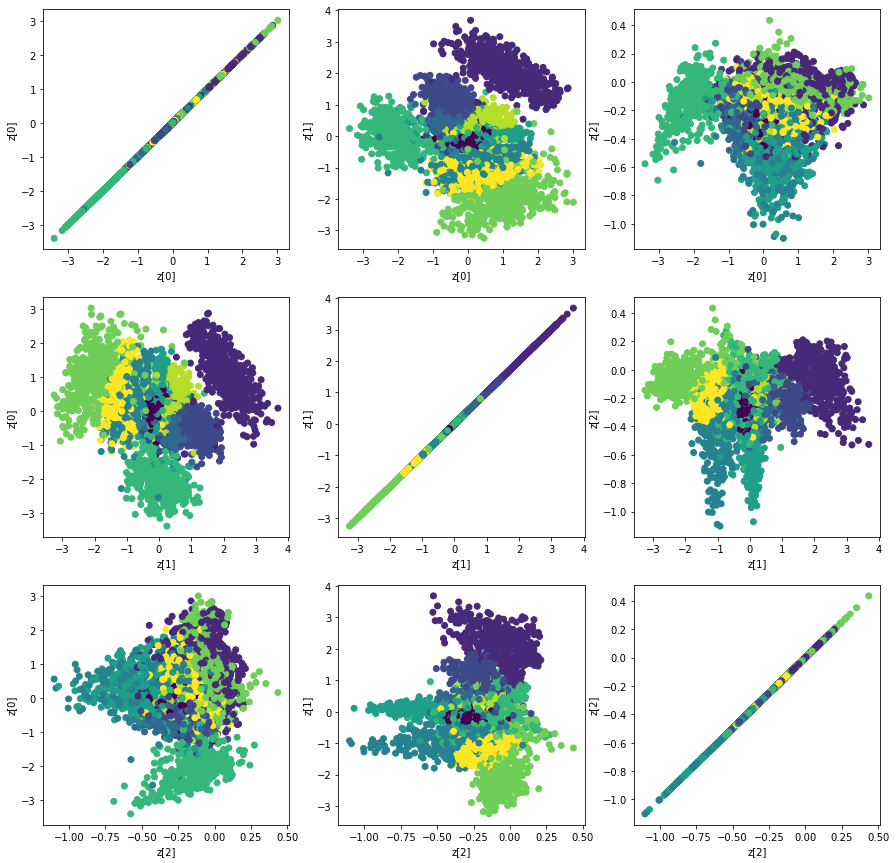

In [50]:
fuzzy_cvae = keras.Model(encoder_inputs, z_mean)
fae_class = keras.Model(encoder_inputs, fz)

def plot_label_clusters(fae, data, labels):
    z_means = fae.predict(data)
    fig, ax = plt.subplots(ncols=latent_dim, nrows=latent_dim, figsize=(15, 15), squeeze=False)
    for bdim in range(latent_dim):
        for odim in range(latent_dim):
            ax[bdim, odim].scatter(z_means[:, bdim], z_means[:, odim], c=labels)
            ax[bdim, odim].set_xlabel(f"z[{bdim}]")
            ax[bdim, odim].set_ylabel(f"z[{odim}]")
    
    plt.show()

labels = [np.argmax(a) for a in Y_val]
plot_label_clusters(fuzzy_cvae, X_val, labels)